In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import pickle

In [2]:
train_data = pd.read_excel(r'C:\Users\harsh\Downloads/Data_Train.xlsx')


In [3]:
test_data = pd.read_excel(r'C:\Users\harsh\Downloads/Test_set.xlsx')

In [4]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
#check for missing values
train_data.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of        Airline  Date_of_Journey  Source  Destination  Route  Dep_Time  \
0        False            False   False        False  False     False   
1        False            False   False        False  False     False   
2        False            False   False        False  False     False   
3        False            False   False        False  False     False   
4        False            False   False        False  False     False   
...        ...              ...     ...          ...    ...       ...   
10678    False            False   False        False  False     False   
10679    False            False   False        False  False     False   
10680    False            False   False        False  False     False   
10681    False            False   False        False  False     False   
10682    False            False   False        False  False     False   

       Arrival_Time  Duration  Total_Stops  Additional_Info  

In [6]:
train_data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
train_data.shape

(10683, 11)

In [8]:
train_data.dropna(inplace = True)

In [9]:
train_data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

# Clean the Data for Modeling

In [10]:
# function to change necessary columns from object to date time
def change_to_time(column):
    train_data[column] = pd.to_datetime(train_data[column])
    

In [11]:
for i in ['Date_of_Journey', 'Dep_Time', 'Arrival_Time']:
    change_to_time(i)

In [12]:
train_data.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [13]:
# create a new column to add a day of journey 
train_data['Journey_Day'] = train_data['Date_of_Journey'].dt.day

In [14]:
# create a new column to add a month of journey 
train_data['Journey_Month'] = train_data['Date_of_Journey'].dt.month

In [15]:
train_data.drop('Date_of_Journey',axis = 1, inplace = True)

In [16]:
#function to get hour of departure or arrival time for each flight
def get_hour(df, col):
    df[col + '_hour'] = df[col].dt.hour
    #function to get hour of departure or arrival time for each flight
def get_min(df, col):
    df[col + '_min'] = df[col].dt.minute


In [17]:
get_hour(train_data, 'Dep_Time')
get_min(train_data, 'Dep_Time')
train_data.drop('Dep_Time', axis = 1, inplace = True)

In [18]:
get_hour(train_data, 'Arrival_Time')
get_min(train_data, 'Arrival_Time')
train_data.drop('Arrival_Time', axis = 1, inplace = True)

In [19]:
# Split the duration into hour in minute
duration=list(train_data['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' '))==2:
        pass
    else:
        if 'h' in duration[i]: # Check if duration contains only hour
             duration[i]=duration[i] + ' 0m' # Adds 0 minute
        else:
             duration[i]='0h '+ duration[i]
    
    

In [20]:
train_data['Duration'] = duration

In [21]:
def hour(hr):
    return hr.split(' ')[0][0:-1]
def minute(hr):
    return hr.split(' ')[1][0:-1]

In [22]:
# Creating new columns Duration Hr and Duration Min to create separate values 
train_data['Duration_Hour'] = train_data['Duration'].apply(hour)
train_data['Duration_Minute'] = train_data['Duration'].apply(minute)

In [23]:
train_data.dtypes

Airline              object
Source               object
Destination          object
Route                object
Duration             object
Total_Stops          object
Additional_Info      object
Price                 int64
Journey_Day           int64
Journey_Month         int64
Dep_Time_hour         int64
Dep_Time_min          int64
Arrival_Time_hour     int64
Arrival_Time_min      int64
Duration_Hour        object
Duration_Minute      object
dtype: object

In [24]:
train_data.drop('Duration', axis = 1, inplace = True)

In [25]:
train_data['Duration_Hour'] = train_data['Duration_Hour'].astype(str).astype(int)
train_data['Duration_Minute'] = train_data['Duration_Minute'].astype(str).astype(int)

In [26]:
# if the type is an Object('O'), a
catCol = [col for col in train_data.columns if train_data[col].dtype == 'O']
catCol    

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [27]:
# if the type is not an Object('O'), a
numCol = [col for col in train_data.columns if train_data[col].dtype != 'O']
numCol  

['Price',
 'Journey_Day',
 'Journey_Month',
 'Dep_Time_hour',
 'Dep_Time_min',
 'Arrival_Time_hour',
 'Arrival_Time_min',
 'Duration_Hour',
 'Duration_Minute']

In [28]:
#Perform feature encoding on the data
categorical = train_data[catCol]
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info


In [29]:
categorical['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

<AxesSubplot:xlabel='Airline', ylabel='Price'>

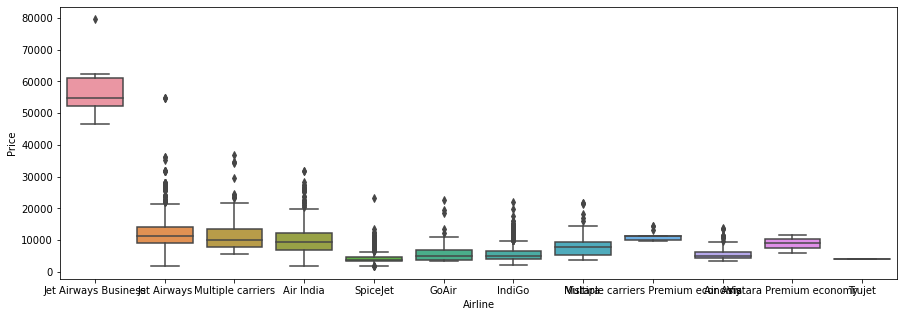

In [30]:
plt.figure(figsize = (15,5))
sns.boxplot(x = 'Airline', y = 'Price', data = train_data.sort_values('Price', ascending = False))

<AxesSubplot:xlabel='Total_Stops', ylabel='Price'>

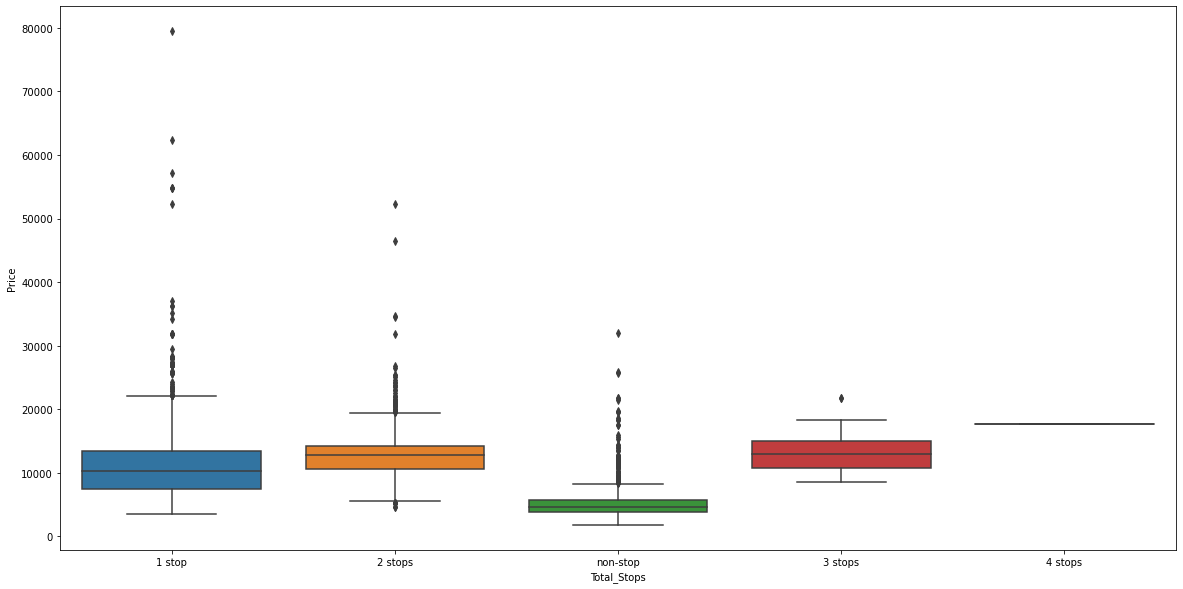

In [31]:
plt.figure(figsize = (20,10))
sns.boxplot(x = 'Total_Stops', y = 'Price', data = train_data.sort_values('Price', ascending = False))

In [32]:
#Convert Airline column to an integer format
Airline = pd.get_dummies(categorical['Airline'], drop_first = True)
Airline.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='Source', ylabel='Price'>

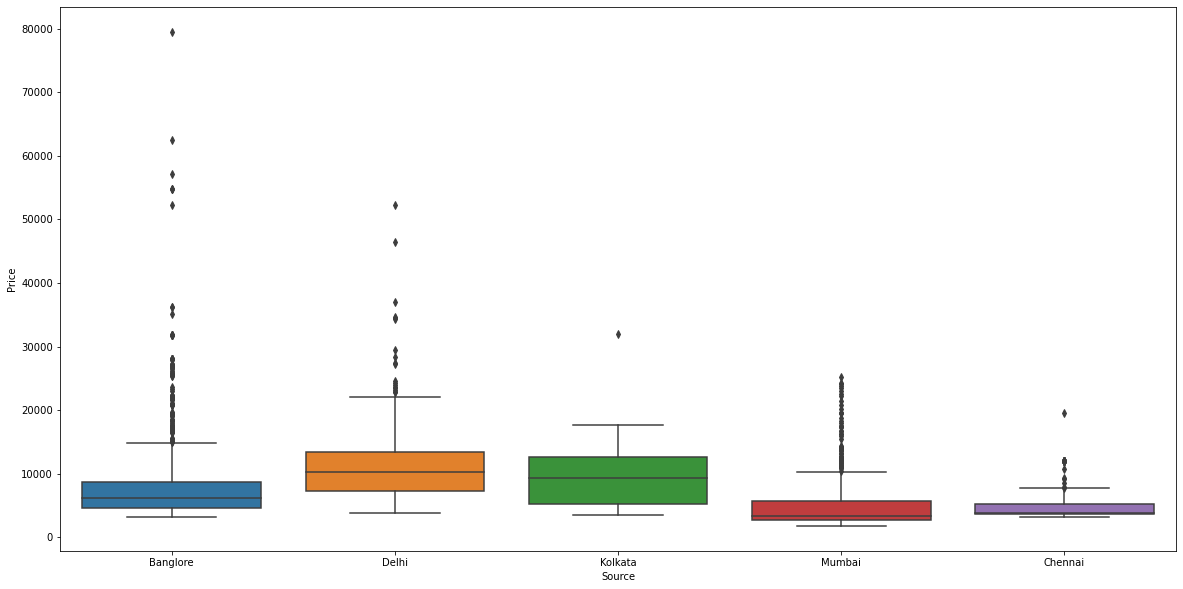

In [33]:
plt.figure(figsize = (20,10))
sns.boxplot(x = 'Source', y = 'Price', data = train_data.sort_values('Price', ascending = False))

In [34]:
train_data['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [35]:
Source = pd.get_dummies(categorical['Source'], drop_first = True)
Source.head()

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [36]:
train_data['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

<AxesSubplot:xlabel='Destination', ylabel='Price'>

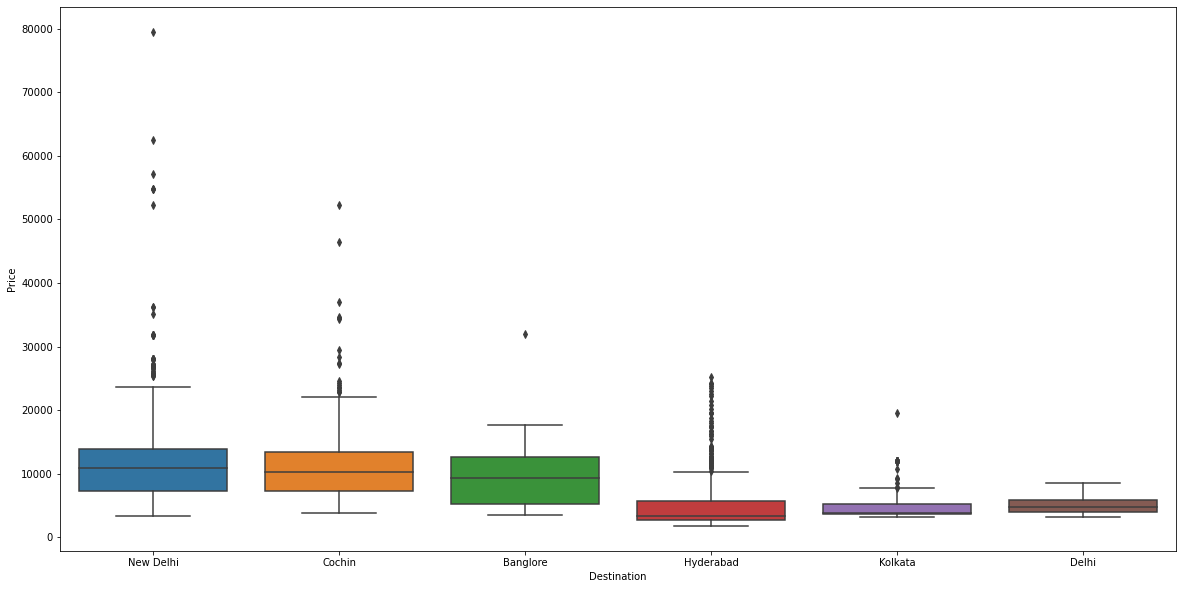

In [37]:
plt.figure(figsize = (20,10))
sns.boxplot(x = 'Destination', y = 'Price', data = train_data.sort_values('Price', ascending = False))

In [38]:
Destination = pd.get_dummies(categorical['Destination'], drop_first = True)
Destination.head()

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [39]:
#Perform label encoding on the Route info (String data)
categorical['Route_1'] = categorical['Route'].str.split('→').str[0]
categorical['Route_2'] = categorical['Route'].str.split('→').str[1]
categorical['Route_3'] = categorical['Route'].str.split('→').str[2]
categorical['Route_4'] = categorical['Route'].str.split('→').str[3]
categorical['Route_5'] = categorical['Route'].str.split('→').str[4]

<ipython-input-39-4cc60860e1c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical['Route_1'] = categorical['Route'].str.split('→').str[0]
<ipython-input-39-4cc60860e1c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical['Route_2'] = categorical['Route'].str.split('→').str[1]
<ipython-input-39-4cc60860e1c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [40]:
categorical.drop('Route', axis = 1, inplace = True)

C:\Users\harsh\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [41]:
#Added 5 route columns
categorical.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,non-stop,No info,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,2 stops,No info,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,2 stops,No info,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,1 stop,No info,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,1 stop,No info,BLR,NAG,DEL,NaN,NaN


In [42]:
# Check how many null values exist in route
categorical.isnull().sum()

Airline                0
Source                 0
Destination            0
Total_Stops            0
Additional_Info        0
Route_1                0
Route_2                0
Route_3             3491
Route_4             9116
Route_5            10636
dtype: int64

In [43]:
# Replace null values with no route 
for i in ['Route_3', 'Route_4', 'Route_5'] :
    categorical[i].fillna('No Route', inplace = True)

C:\Users\harsh\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [44]:
categorical.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Additional_Info    0
Route_1            0
Route_2            0
Route_3            0
Route_4            0
Route_5            0
dtype: int64

In [45]:
encoder = LabelEncoder()

In [46]:
categorical.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'],
      dtype='object')

In [47]:
for i in ['Route_1', 'Route_2','Route_3', 'Route_4', 'Route_5'] :
    categorical[i] = encoder.fit_transform(categorical[i])

<ipython-input-47-6351d975b1cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical[i] = encoder.fit_transform(categorical[i])


In [48]:
categorical.drop('Additional_Info', axis = 1, inplace = True)

C:\Users\harsh\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [49]:
categorical['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [50]:
dict = {'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops': 4}

In [51]:
categorical['Total_Stops'] = categorical['Total_Stops'].map(dict)

<ipython-input-51-6b9ec31b02d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical['Total_Stops'] = categorical['Total_Stops'].map(dict)


In [52]:
categorical.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5
1,Air India,Kolkata,Banglore,2,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5


In [53]:
# Put all the numerical data together
data_train = pd.concat([categorical,Airline, Source, Destination, train_data[numCol]], axis = 1)

In [54]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,...,New Delhi,Price,Journey_Day,Journey_Month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_Hour,Duration_Minute
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5,0,...,1,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,2,25,1,3,5,1,...,0,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5,0,...,0,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5,0,...,0,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5,0,...,1,13302,3,1,16,50,21,35,4,45


In [55]:
data_train.drop('Source', axis = 1, inplace = True)
data_train.drop('Destination', axis = 1, inplace = True)
data_train.drop('Airline', axis = 1, inplace = True)

In [56]:
pd.set_option('display.max_columns', 35)

In [57]:
data_train.head()

,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,Journey_Day,Journey_Month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_Hour,Duration_Minute
0,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3897,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7662,5,1,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,13882,6,9,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6218,5,12,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13302,3,1,16,50,21,35,4,45


In [58]:
# Deal with outliers 
def plot(df, col) :
    fig, (ax1, ax2) = plt.subplots(2,1)
    sns.distplot(df[col], ax = ax1)
    sns.boxplot(df[col], ax = ax2)
    


C:\Users\harsh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\harsh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


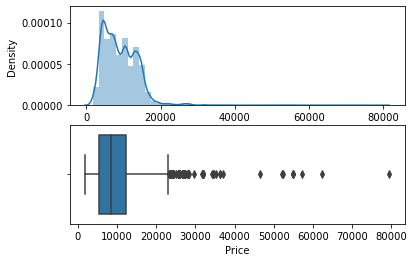

In [59]:
plot(data_train, 'Price')

In [60]:
# To handle outliers, whereve the price is >= 4000, then replace it with the median, if not keep it the same
data_train['Price'] = np.where(data_train['Price'] >= 4000, data_train['Price'].median(),data_train['Price'])

C:\Users\harsh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\harsh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


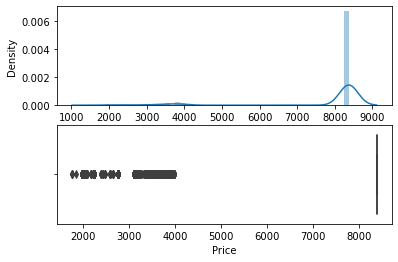

In [61]:
plot(data_train, 'Price')

In [62]:
X = data_train.drop('Price', axis =1) 
X.head()

,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Journey_Day,Journey_Month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_Hour,Duration_Minute
0,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5,1,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,6,9,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5,12,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,16,50,21,35,4,45


In [63]:
X.shape

(10682, 34)

In [64]:
y = data_train['Price']
y

0        3897.0
1        8372.0
2        8372.0
3        8372.0
4        8372.0
          ...  
10678    8372.0
10679    8372.0
10680    8372.0
10681    8372.0
10682    8372.0
Name: Price, Length: 10682, dtype: float64

In [65]:
 mutual_info_classif(X, y)

array([1.36994116e-01, 3.06518610e-01, 3.40178066e-01, 1.82363697e-01,
       6.44123095e-02, 3.21355147e-02, 2.90613426e-02, 1.91079980e-02,
       7.60173209e-02, 6.79266746e-02, 0.00000000e+00, 2.08096106e-02,
       0.00000000e+00, 1.51893316e-01, 4.53766498e-05, 1.14282390e-02,
       0.00000000e+00, 8.68437376e-02, 6.08027144e-02, 6.27822696e-02,
       1.30621361e-01, 6.21841876e-02, 7.60514329e-02, 1.39341884e-01,
       9.11522728e-02, 6.19603862e-03, 2.40639451e-02, 2.96827757e-02,
       1.78956207e-01, 1.29344679e-01, 2.03321764e-01, 1.39976129e-01,
       2.72373801e-01, 1.67848026e-01])

In [66]:
imp = pd.DataFrame( mutual_info_classif(X, y), index = X.columns)
imp

,0
Total_Stops,0.138627
Route_1,0.304131
Route_2,0.339452
Route_3,0.180340
Route_4,0.072730
Route_5,0.030825
Air India,0.030510
GoAir,0.019914
IndiGo,0.076852
Jet Airways,0.063386


In [67]:
imp.columns = ['importance']
imp.sort_values(by = 'importance', ascending=False)

,importance
Route_2,0.339452
Route_1,0.304131
Duration_Hour,0.268007
Arrival_Time_hour,0.199250
Route_3,0.180340
Dep_Time_hour,0.174112
Duration_Minute,0.171167
Arrival_Time_min,0.148588
SpiceJet,0.145586
Total_Stops,0.138627


In [68]:
train_data.dtypes

Airline              object
Source               object
Destination          object
Route                object
Total_Stops          object
Additional_Info      object
Price                 int64
Journey_Day           int64
Journey_Month         int64
Dep_Time_hour         int64
Dep_Time_min          int64
Arrival_Time_hour     int64
Arrival_Time_min      int64
Duration_Hour         int32
Duration_Minute       int32
dtype: object

In [69]:
# Build an ML model to test the data and Automate Predictions

In [70]:
# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [71]:
def predict(ml_model, dump) :
    model = ml_model.fit(X_train, y_train)
    print('Training Score: {}'.format(model.score(X_train, y_train)) )
    y_pred = model.predict(X_test)
    print('Predictions: {}'.format(y_pred))
    
    # R^2 score - measuring the amount of variance in the predictions
    r2_score = metrics.r2_score(y_test, y_pred)
    print('R^2 score: {}'.format(r2_score))
    
    # Mean Absolute Error is magnitude of difference between the prediction of an observation and the true value of that observation
    print('Mean Absolute Error(MAE): {}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    
    # Mean Squared Error is 
    print('Mean Squared Error(MSE): {}'.format(metrics.mean_squared_error(y_test, y_pred)))
    
    print('Root Mean Squared Error(RMSE): {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
    # In y_test, there will be the flight fare values and in y_pred there will be the predicted fares based on what ML Model is Used
    # Normal Distribution is good
    sns.distplot(y_pred - y_test)
  
    if(dump == 1) :
        file = open(r'C:\Users\harsh\Downloads/Data_Train.xlsx')
        pickle.dump(model, file)

Training Score: 0.9476504634978699
Predictions: [8372.         8372.         8372.         ... 8372.         3933.03333333
 5117.30514286]
R^2 score: 0.7681105756432609
Mean Absolute Error(MAE): 186.84427282337447
Mean Squared Error(MSE): 552880.9218425474
Root Mean Squared Error(RMSE): 743.5596289757449


C:\Users\harsh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


TypeError: write() argument must be str, not bytes

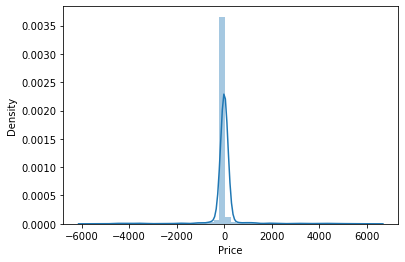

In [72]:
predict(RandomForestRegressor(), 1)

Training Score: 0.5095537291218843
Predictions: [8853.57645245 8407.05588779 7294.5560666  ... 8528.04538438 5896.34080683
 5612.47759083]
R^2 score: 0.4897001448438921
Mean Absolute Error(MAE): 660.5473001727488
Mean Squared Error(MSE): 1216679.2647722918
Root Mean Squared Error(RMSE): 1103.0318512048018


C:\Users\harsh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


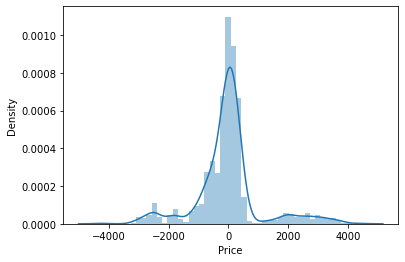

In [73]:
predict(LinearRegression(), 0)

Training Score: 0.9687946814414161
Predictions: [8372. 8372. 8372. ... 8372. 3841. 8372.]
R^2 score: 0.6675622263688851
Mean Absolute Error(MAE): 173.72002995132908
Mean Squared Error(MSE): 792612.699998336
Root Mean Squared Error(RMSE): 890.2879871133475


C:\Users\harsh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


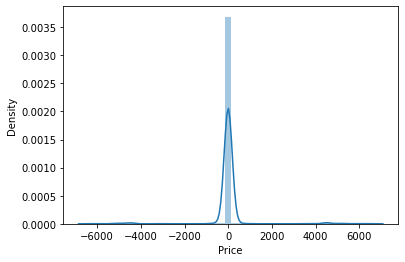

In [74]:
predict(DecisionTreeRegressor(), 0)